# Reinforcement Learning: Exploration using Improved Bayesian Q-Network

In [11]:
from __future__ import division

import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.contrib.slim as slim

### Load the environment

In [12]:
env = gym.make('CartPole-v0')

## The Deep Q-Network 

### Helper functions

In [3]:
class experience_buffer():
    def __init__(self, buffer_size = 10000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])
    
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

### Implementing the network itself

In [4]:
class Q_Network():
    def __init__(self):
        #These lines establish the feed-forward part of the network used to choose actions
        self.inputs = tf.placeholder(shape=[None,4],dtype=tf.float32)
        self.Temp = tf.placeholder(shape=None,dtype=tf.float32)
        self.keep_per = tf.placeholder(shape=None,dtype=tf.float32)

        hidden = slim.fully_connected(self.inputs,64,activation_fn=tf.nn.tanh,biases_initializer=None)
        hidden = slim.dropout(hidden,self.keep_per)
        self.Q_out = slim.fully_connected(hidden,2,activation_fn=None,biases_initializer=None)
        
        self.predict = tf.argmax(self.Q_out,1)
        self.Q_dist = tf.nn.softmax(self.Q_out/self.Temp)
        
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,2,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Q_out, self.actions_onehot), reduction_indices=1)
        
        self.nextQ = tf.placeholder(shape=[None],dtype=tf.float32)
        loss = tf.reduce_sum(tf.square(self.nextQ - self.Q))
        trainer = tf.train.GradientDescentOptimizer(learning_rate=0.0005)
        self.updateModel = trainer.minimize(loss)

### Training the network

In [5]:
# Set learning parameters
exploration = "e-greedy" #Exploration method. Choose between: greedy, random, e-greedy, boltzmann, bayesian.
y = .99 #Discount factor.
num_episodes = 20000 #Total number of episodes to train network for.
tau = 0.001 #Amount to update target network at each step.
batch_size = 32 #Size of training batch
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
anneling_steps = 200000 #How many steps of training to reduce startE to endE.
pre_train_steps = 50000 #Number of steps used before training updates begin.

In [9]:
def choice(exploration):
    tf.reset_default_graph()

    q_net = Q_Network()
    target_net = Q_Network()

    init = tf.initialize_all_variables()
    trainables = tf.trainable_variables()
    targetOps = updateTargetGraph(trainables,tau)
    myBuffer = experience_buffer()


    #create lists to contain total rewards and steps per episode
    jList = []
    jMeans = []
    rList = []
    rMeans = []
    with tf.Session() as sess:
        sess.run(init)
        updateTarget(targetOps,sess)
        e = startE
        stepDrop = (startE - endE)/anneling_steps
        total_steps = 0

        for i in range(num_episodes):
            s = env.reset()
            rAll = 0
            d = False
            j = 0
            while j < 999:
                j+=1
                if exploration == "greedy":
                    #Choose an action with the maximum expected value.
                    a,allQ = sess.run([q_net.predict,q_net.Q_out],feed_dict={q_net.inputs:[s],q_net.keep_per:1.0})
                    a = a[0]
                if exploration == "random":
                    #Choose an action randomly.
                    a = env.action_space.sample()
                if exploration == "e-greedy":
                    #Choose an action by greedily (with e chance of random action) from the Q-network
                    if np.random.rand(1) < e or total_steps < pre_train_steps:
                        a = env.action_space.sample()
                    else:
                        a,allQ = sess.run([q_net.predict,q_net.Q_out],feed_dict={q_net.inputs:[s],q_net.keep_per:1.0})
                        a = a[0]
                if exploration == "boltzmann":
                    #Choose an action probabilistically, with weights relative to the Q-values.
                    Q_d,allQ = sess.run([q_net.Q_dist,q_net.Q_out],feed_dict={q_net.inputs:[s],q_net.Temp:e,q_net.keep_per:1.0})
                    a = np.random.choice(Q_d[0],p=Q_d[0])
                    a = np.argmax(Q_d[0] == a)
                if exploration == "bayesian":
                    #Choose an action using a sample from a dropout approximation of a bayesian q-network.
                    a,allQ = sess.run([q_net.predict,q_net.Q_out],feed_dict={q_net.inputs:[s],q_net.keep_per:(1-e)+0.1})
                    a = a[0]

                #Get new state and reward from environment
                s1,r,d,_ = env.step(a)
                myBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5]))

                if e > endE and total_steps > pre_train_steps:
                    e -= stepDrop

                if total_steps > pre_train_steps and total_steps % 5 == 0:
                    #We use Double-DQN training algorithm
                    trainBatch = myBuffer.sample(batch_size)
                    Q1 = sess.run(q_net.predict,feed_dict={q_net.inputs:np.vstack(trainBatch[:,3]),q_net.keep_per:1.0})
                    Q2 = sess.run(target_net.Q_out,feed_dict={target_net.inputs:np.vstack(trainBatch[:,3]),target_net.keep_per:1.0})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    _ = sess.run(q_net.updateModel,feed_dict={q_net.inputs:np.vstack(trainBatch[:,0]),q_net.nextQ:targetQ,q_net.keep_per:1.0,q_net.actions:trainBatch[:,1]})
                    updateTarget(targetOps,sess)

                rAll += r
                s = s1
                total_steps += 1
                if d == True:
                    break
            jList.append(j)
            rList.append(rAll)
            if i % 100 == 0 and i != 0:
                r_mean = np.mean(rList[-100:])
                j_mean = np.mean(jList[-100:])
                if exploration == 'e-greedy':
                    print("Mean Reward: " + str(r_mean) + " Total Steps: " + str(total_steps) + " e: " + str(e))
                if exploration == 'boltzmann':
                    print("Mean Reward: " + str(r_mean) + " Total Steps: " + str(total_steps) + " t: " + str(e))
                if exploration == 'bayesian':
                    print("Mean Reward: " + str(r_mean) + " Total Steps: " + str(total_steps) + " p: " + str(e))
                if exploration == 'random' or exploration == 'greedy':
                    print("Mean Reward: " + str(r_mean) + " Total Steps: " + str(total_steps))
                rMeans.append(r_mean)
                jMeans.append(j_mean)
    print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")
    return(rMeans, jMeans)

### Some statistics on network performance

In [10]:
greedy_rmeans, greedy_jmeans = choice("greedy")
e_greedy_rmeans, e_greedy_jmeans = choice("e-greedy")
random_rmeans, random_jmeans = choice("random")
boltzmann_rmeans, boltzmann_jmeans = choice("boltzmann")
bayesian_rmeans, bayesian_jmeans = choice("bayesian")
#Exploration method. Choose between: greedy, random, e-greedy, boltzmann, bayesian.


#plt.plot(rMeans)

Mean Reward: 9.26 Total Steps: 935
Mean Reward: 9.23 Total Steps: 1858
Mean Reward: 9.36 Total Steps: 2794
Mean Reward: 9.23 Total Steps: 3717
Mean Reward: 9.25 Total Steps: 4642
Mean Reward: 9.2 Total Steps: 5562
Mean Reward: 9.36 Total Steps: 6498
Mean Reward: 9.26 Total Steps: 7424
Mean Reward: 9.15 Total Steps: 8339
Mean Reward: 9.23 Total Steps: 9262
Mean Reward: 9.34 Total Steps: 10196
Mean Reward: 9.21 Total Steps: 11117
Mean Reward: 9.37 Total Steps: 12054
Mean Reward: 9.29 Total Steps: 12983
Mean Reward: 9.29 Total Steps: 13912
Mean Reward: 9.17 Total Steps: 14829
Mean Reward: 9.33 Total Steps: 15762
Mean Reward: 9.3 Total Steps: 16692
Mean Reward: 9.35 Total Steps: 17627
Mean Reward: 9.31 Total Steps: 18558
Mean Reward: 9.33 Total Steps: 19491
Mean Reward: 9.27 Total Steps: 20418
Mean Reward: 9.26 Total Steps: 21344
Mean Reward: 9.18 Total Steps: 22262
Mean Reward: 9.18 Total Steps: 23180
Mean Reward: 9.26 Total Steps: 24106
Mean Reward: 9.16 Total Steps: 25022
Mean Reward: 9

Mean Reward: 21.01 Total Steps: 50958 e: 0.9956935000000355
Mean Reward: 21.78 Total Steps: 53136 e: 0.9858925000001164
Mean Reward: 21.64 Total Steps: 55300 e: 0.9761545000001968
Mean Reward: 22.58 Total Steps: 57558 e: 0.9659935000002806
Mean Reward: 22.89 Total Steps: 59847 e: 0.9556930000003656
Mean Reward: 20.9 Total Steps: 61937 e: 0.9462880000004432
Mean Reward: 21.36 Total Steps: 64073 e: 0.9366760000005225
Mean Reward: 22.64 Total Steps: 66337 e: 0.9264880000006066
Mean Reward: 20.03 Total Steps: 68340 e: 0.917474500000681
Mean Reward: 21.05 Total Steps: 70445 e: 0.9080020000007591
Mean Reward: 19.11 Total Steps: 72356 e: 0.8994025000008301
Mean Reward: 21.03 Total Steps: 74459 e: 0.8899390000009082
Mean Reward: 19.42 Total Steps: 76401 e: 0.8812000000009803
Mean Reward: 19.79 Total Steps: 78380 e: 0.8722945000010538
Mean Reward: 17.3 Total Steps: 80110 e: 0.864509500001118
Mean Reward: 19.49 Total Steps: 82059 e: 0.8557390000011904
Mean Reward: 19.81 Total Steps: 84040 e: 0.8

Mean Reward: 10.2 Total Steps: 234412 e: 0.17015050000327128
Mean Reward: 9.97 Total Steps: 235409 e: 0.16566400000328063
Mean Reward: 9.87 Total Steps: 236396 e: 0.1612225000032899
Mean Reward: 10.0 Total Steps: 237396 e: 0.15672250000329926
Mean Reward: 9.87 Total Steps: 238383 e: 0.15228100000330852
Mean Reward: 9.82 Total Steps: 239365 e: 0.14786200000331773
Mean Reward: 9.75 Total Steps: 240340 e: 0.14347450000332687
Mean Reward: 9.9 Total Steps: 241330 e: 0.13901950000333615
Mean Reward: 9.69 Total Steps: 242299 e: 0.13465900000334524
Mean Reward: 9.74 Total Steps: 243273 e: 0.13027600000335438
Mean Reward: 9.83 Total Steps: 244256 e: 0.1258525000033636
Mean Reward: 9.63 Total Steps: 245219 e: 0.12151900000336188
Mean Reward: 9.73 Total Steps: 246192 e: 0.1171405000033575
Mean Reward: 9.69 Total Steps: 247161 e: 0.11278000000335314
Mean Reward: 9.64 Total Steps: 248125 e: 0.1084420000033488
Mean Reward: 9.64 Total Steps: 249089 e: 0.10410400000334447
Mean Reward: 9.67 Total Steps

Mean Reward: 22.18 Total Steps: 328697
Mean Reward: 24.43 Total Steps: 331140
Mean Reward: 21.45 Total Steps: 333285
Mean Reward: 22.94 Total Steps: 335579
Mean Reward: 21.88 Total Steps: 337767
Mean Reward: 21.07 Total Steps: 339874
Mean Reward: 22.02 Total Steps: 342076
Mean Reward: 22.32 Total Steps: 344308
Mean Reward: 23.2 Total Steps: 346628
Mean Reward: 24.62 Total Steps: 349090
Mean Reward: 19.89 Total Steps: 351079
Mean Reward: 19.41 Total Steps: 353020
Mean Reward: 20.54 Total Steps: 355074
Mean Reward: 20.78 Total Steps: 357152
Mean Reward: 20.83 Total Steps: 359235
Mean Reward: 20.87 Total Steps: 361322
Mean Reward: 21.98 Total Steps: 363520
Mean Reward: 23.05 Total Steps: 365825
Mean Reward: 22.44 Total Steps: 368069
Mean Reward: 22.73 Total Steps: 370342
Mean Reward: 22.2 Total Steps: 372562
Mean Reward: 23.32 Total Steps: 374894
Mean Reward: 21.65 Total Steps: 377059
Mean Reward: 23.55 Total Steps: 379414
Mean Reward: 22.8 Total Steps: 381694
Mean Reward: 22.86 Total Ste

Mean Reward: 26.89 Total Steps: 352317 t: 0.09999550000334036
Mean Reward: 27.45 Total Steps: 355062 t: 0.09999550000334036
Mean Reward: 27.38 Total Steps: 357800 t: 0.09999550000334036
Mean Reward: 27.02 Total Steps: 360502 t: 0.09999550000334036
Mean Reward: 28.04 Total Steps: 363306 t: 0.09999550000334036
Mean Reward: 26.57 Total Steps: 365963 t: 0.09999550000334036
Mean Reward: 26.58 Total Steps: 368621 t: 0.09999550000334036
Mean Reward: 26.59 Total Steps: 371280 t: 0.09999550000334036
Mean Reward: 27.68 Total Steps: 374048 t: 0.09999550000334036
Mean Reward: 27.19 Total Steps: 376767 t: 0.09999550000334036
Mean Reward: 27.99 Total Steps: 379566 t: 0.09999550000334036
Mean Reward: 26.73 Total Steps: 382239 t: 0.09999550000334036
Mean Reward: 27.11 Total Steps: 384950 t: 0.09999550000334036
Mean Reward: 27.6 Total Steps: 387710 t: 0.09999550000334036
Mean Reward: 29.0 Total Steps: 390610 t: 0.09999550000334036
Mean Reward: 28.39 Total Steps: 393449 t: 0.09999550000334036
Mean Rewar

Mean Reward: 12.88 Total Steps: 74429 p: 0.8900740000009071
Mean Reward: 13.63 Total Steps: 75792 p: 0.8839405000009577
Mean Reward: 14.71 Total Steps: 77263 p: 0.8773210000010123
Mean Reward: 15.27 Total Steps: 78790 p: 0.870449500001069
Mean Reward: 16.75 Total Steps: 80465 p: 0.8629120000011312
Mean Reward: 17.01 Total Steps: 82166 p: 0.8552575000011944
Mean Reward: 16.89 Total Steps: 83855 p: 0.8476570000012571
Mean Reward: 18.0 Total Steps: 85655 p: 0.8395570000013239
Mean Reward: 17.7 Total Steps: 87425 p: 0.8315920000013897
Mean Reward: 19.07 Total Steps: 89332 p: 0.8230105000014605
Mean Reward: 17.84 Total Steps: 91116 p: 0.8149825000015267
Mean Reward: 17.14 Total Steps: 92830 p: 0.8072695000015904
Mean Reward: 17.89 Total Steps: 94619 p: 0.7992190000016568
Mean Reward: 18.3 Total Steps: 96449 p: 0.7909840000017248
Mean Reward: 16.53 Total Steps: 98102 p: 0.7835455000017861
Mean Reward: 17.46 Total Steps: 99848 p: 0.775688500001851
Mean Reward: 16.39 Total Steps: 101487 p: 0.7

Mean Reward: 164.06 Total Steps: 1032507 p: 0.09999550000334036
Mean Reward: 171.5 Total Steps: 1049657 p: 0.09999550000334036
Mean Reward: 167.68 Total Steps: 1066425 p: 0.09999550000334036
Mean Reward: 164.46 Total Steps: 1082871 p: 0.09999550000334036
Mean Reward: 170.83 Total Steps: 1099954 p: 0.09999550000334036
Mean Reward: 170.56 Total Steps: 1117010 p: 0.09999550000334036
Mean Reward: 184.69 Total Steps: 1135479 p: 0.09999550000334036
Mean Reward: 168.29 Total Steps: 1152308 p: 0.09999550000334036
Mean Reward: 172.18 Total Steps: 1169526 p: 0.09999550000334036
Mean Reward: 173.36 Total Steps: 1186862 p: 0.09999550000334036
Mean Reward: 169.71 Total Steps: 1203833 p: 0.09999550000334036
Mean Reward: 175.01 Total Steps: 1221334 p: 0.09999550000334036
Mean Reward: 172.88 Total Steps: 1238622 p: 0.09999550000334036
Mean Reward: 168.13 Total Steps: 1255435 p: 0.09999550000334036
Mean Reward: 171.69 Total Steps: 1272604 p: 0.09999550000334036
Mean Reward: 175.03 Total Steps: 1290107 

Text(0, 0.5, 'Time Steps')

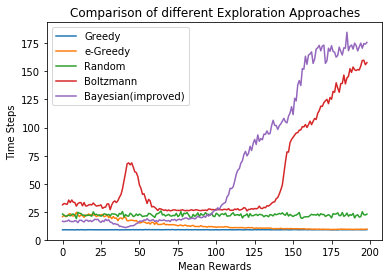

In [20]:

plt.plot(greedy_rmeans)
plt.plot(e_greedy_rmeans)
plt.plot(random_rmeans)
plt.plot(boltzmann_rmeans)
plt.plot(bayesian_rmeans)
plt.legend(['Greedy', 'e-Greedy', 'Random', 'Boltzmann', 'Bayesian(improved)'], loc='upper left')
plt.title('Comparison of different Exploration Approaches')
plt.xlabel('Mean Rewards')
plt.ylabel('Time Steps')